In [18]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"


from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [19]:
from clsar.dataset import LSSNS # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACNet_GCN, ACNet_GIN, ACNet_GAT, ACNet_PNA # model
from clsar.model.loss import ada_batch_all_triplet_loss

In [20]:
dataset_name = 'mglur2'
Dataset =  LSSNS # MoleculeNet
epochs = 800

pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '/tmp/mydata'

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

Processing...
Done!


In [21]:
batch_size = 128

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [22]:
## data HPs
cliff = 0.5
weight = 1

## model HPs
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1, 
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.0, 'batch_norms':None}

model = ACNet_GAT(**pub_args, heads = 3, dropout= 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)


def train(train_loader):
    total_examples = 0
    total_loss =  0    
    total_triplet_loss = 0
    total_mae_loss = 0   
    n_triplets = []
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        loss_out = ada_batch_all_triplet_loss(embeddings = embeddings,
                                              predictions = predictions,
                                              labels = data.y, 
                                              device = device, 
                                              cliff=cliff,
                                              alpha=weight)
        loss, triplet_loss, mae_loss, num_positive_triplets = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_triplet_loss += float(triplet_loss) * data.num_graphs        
        total_mae_loss += float(mae_loss) * data.num_graphs        
        total_examples += data.num_graphs
        n_triplets.append(int(num_positive_triplets))
        
    train_loss = total_loss / total_examples
    total_triplet_loss = total_triplet_loss / total_examples
    total_mae_loss = total_mae_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    
    return train_loss, total_triplet_loss, total_mae_loss, n_triplets


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
        
    return float(torch.cat(mse, dim=0).mean().sqrt())


history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, triplet_loss, mae_loss, n_triplets = train(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} TripLoss: {triplet_loss:.4f} MAELoss: {mae_loss:.4f} '
          f'Triplets: {n_triplets:03d}; Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':triplet_loss,'train_mae_loss':mae_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'triplets': n_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df1 = pd.DataFrame(history)

Epoch: 001, Loss: 8.4637 TripLoss: 0.5712 MAELoss: 7.8925 Triplets: 222930; Val: 7.8877 Test: 8.0712
Epoch: 002, Loss: 8.4393 TripLoss: 0.5728 MAELoss: 7.8665 Triplets: 223390; Val: 7.8622 Test: 8.0453
Epoch: 003, Loss: 8.4160 TripLoss: 0.5748 MAELoss: 7.8412 Triplets: 224838; Val: 7.8369 Test: 8.0201
Epoch: 004, Loss: 8.3924 TripLoss: 0.5769 MAELoss: 7.8155 Triplets: 229420; Val: 7.8110 Test: 7.9946
Epoch: 005, Loss: 8.3641 TripLoss: 0.5744 MAELoss: 7.7897 Triplets: 221646; Val: 7.7851 Test: 7.9688
Epoch: 006, Loss: 8.3338 TripLoss: 0.5702 MAELoss: 7.7635 Triplets: 219165; Val: 7.7583 Test: 7.9419
Epoch: 007, Loss: 8.3065 TripLoss: 0.5698 MAELoss: 7.7368 Triplets: 225972; Val: 7.7307 Test: 7.9149
Epoch: 008, Loss: 8.2744 TripLoss: 0.5652 MAELoss: 7.7092 Triplets: 220679; Val: 7.7026 Test: 7.8863
Epoch: 009, Loss: 8.2484 TripLoss: 0.5676 MAELoss: 7.6807 Triplets: 220184; Val: 7.6719 Test: 7.8563
Epoch: 010, Loss: 8.2267 TripLoss: 0.5757 MAELoss: 7.6510 Triplets: 222792; Val: 7.6407 Tes

In [23]:
weight = 0.0

model = ACNet_GAT(**pub_args, heads = 3, dropout= 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

def train(train_loader):
    total_examples = 0
    total_loss =  0    
    total_triplet_loss = 0
    total_mae_loss = 0   
    n_triplets = []
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        loss_out = ada_batch_all_triplet_loss(embeddings = embeddings,
                                              predictions = predictions,
                                              labels = data.y, 
                                              device = device, 
                                              cliff=cliff,
                                              alpha=weight)
        loss, triplet_loss, mae_loss, num_positive_triplets = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_triplet_loss += float(triplet_loss) * data.num_graphs        
        total_mae_loss += float(mae_loss) * data.num_graphs        
        total_examples += data.num_graphs
        n_triplets.append(int(num_positive_triplets))
        
    train_loss = total_loss / total_examples
    total_triplet_loss = total_triplet_loss / total_examples
    total_mae_loss = total_mae_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    
    return train_loss, total_triplet_loss, total_mae_loss, n_triplets


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
        
    return float(torch.cat(mse, dim=0).mean().sqrt())


history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, triplet_loss, mae_loss, n_triplets = train(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} TripLoss: {triplet_loss:.4f} MAELoss: {mae_loss:.4f} '
          f'Triplets: {n_triplets:03d}; Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':triplet_loss,'train_mae_loss':mae_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'triplets': n_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df2 = pd.DataFrame(history)

Epoch: 001, Loss: 7.8915 TripLoss: 0.5714 MAELoss: 7.8915 Triplets: 220370; Val: 7.8812 Test: 8.0650
Epoch: 002, Loss: 7.8589 TripLoss: 0.5731 MAELoss: 7.8589 Triplets: 223216; Val: 7.8489 Test: 8.0324
Epoch: 003, Loss: 7.8274 TripLoss: 0.5690 MAELoss: 7.8274 Triplets: 219039; Val: 7.8177 Test: 8.0005
Epoch: 004, Loss: 7.7952 TripLoss: 0.5673 MAELoss: 7.7952 Triplets: 223909; Val: 7.7859 Test: 7.9701
Epoch: 005, Loss: 7.7639 TripLoss: 0.5798 MAELoss: 7.7639 Triplets: 228612; Val: 7.7550 Test: 7.9379
Epoch: 006, Loss: 7.7337 TripLoss: 0.5721 MAELoss: 7.7337 Triplets: 224807; Val: 7.7244 Test: 7.9080
Epoch: 007, Loss: 7.7020 TripLoss: 0.5717 MAELoss: 7.7020 Triplets: 222305; Val: 7.6932 Test: 7.8769
Epoch: 008, Loss: 7.6701 TripLoss: 0.5691 MAELoss: 7.6701 Triplets: 226453; Val: 7.6616 Test: 7.8429
Epoch: 009, Loss: 7.6382 TripLoss: 0.5663 MAELoss: 7.6382 Triplets: 223606; Val: 7.6277 Test: 7.8111
Epoch: 010, Loss: 7.6046 TripLoss: 0.5747 MAELoss: 7.6046 Triplets: 223445; Val: 7.5914 Tes

<AxesSubplot:>

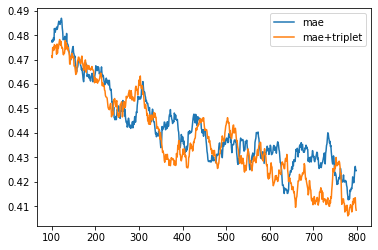

In [24]:
df2.val_rmse.to_frame(name = 'mae').join(df1.val_rmse.to_frame(name = 'mae+triplet')).rolling(20).mean().iloc[100:].plot()

<AxesSubplot:>

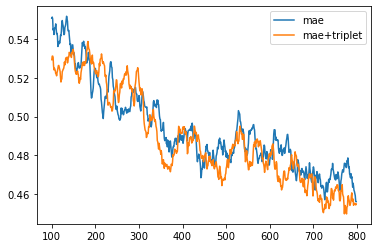

In [25]:
df2.test_rmse.to_frame(name = 'mae').join(df1.test_rmse.to_frame(name = 'mae+triplet')).rolling(20).mean().iloc[100:].plot()

<AxesSubplot:>

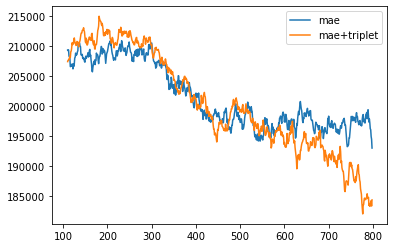

In [26]:
df2.triplets.to_frame(name = 'mae').join(df1.triplets.to_frame(name = 'mae+triplet')).rolling(10).mean().iloc[110:].plot()